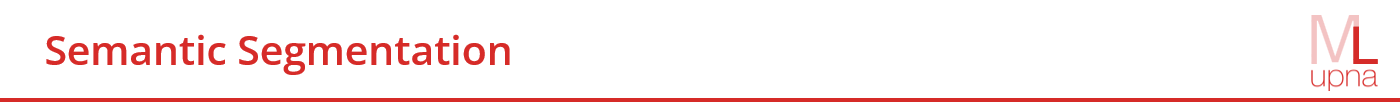

In [47]:
# Buid dataset from folder structure

from glob import glob
import pandas as pd

images = glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df.image_path.apply(lambda x : x.replace('/images/', '/labels/').replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x : x.split('/')[2])
df.head()

,image_path,mask_path,set
0,./clothes/test/images/0851.jpg,./clothes/test/labels/0851.png,test
1,./clothes/test/images/0852.jpg,./clothes/test/labels/0852.png,test
2,./clothes/test/images/0853.jpg,./clothes/test/labels/0853.png,test
3,./clothes/test/images/0854.jpg,./clothes/test/labels/0854.png,test
4,./clothes/test/images/0855.jpg,./clothes/test/labels/0855.png,test


In [48]:
import pytorch_lightning as pl
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.models import ResNet50_Weights
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score
from skimage.io import imread  # or your preferred image loader
from segmentation_models_pytorch.losses import DiceLoss




In [49]:
DATA_DIR = 'clothes'
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_name'].tolist()
# Rewriting 'null' class to prevent a NaN value 
class_names[0] = 'null'
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('\nClass Names: ', class_names)
print('\nClass RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:

Class Names:  ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

Class RGB values:  [[69, 6, 90], [70, 12, 95], [71, 18, 101], [72, 25, 107], [72, 30, 112], [72, 35, 116], [71, 40, 120], [70, 47, 124], [69, 52, 127], [68, 57, 130], [66, 61, 132], [64, 67, 135], [62, 72, 136], [61, 76, 137], [58, 82, 139], [56, 86, 139], [54, 90, 140], [52, 94, 141], [50, 99, 141], [48, 103, 141], [46, 107, 142], [

In [50]:
def rgb_to_class(mask, class_rgb_values):
    """
    Convert an RGB segmentation mask to a class index mask.
    mask: (H, W, 3)
    returns: (H, W) with class IDs.
    """
    h, w, _ = mask.shape
    mask_flat = mask.reshape(-1, 3)

    class_id_mask = np.zeros((h*w,), dtype=np.uint8)

    for class_id, rgb in enumerate(class_rgb_values):
        matches = np.all(mask_flat == rgb, axis=-1)
        class_id_mask[matches] = class_id

    return class_id_mask.reshape(h, w)


def class_to_rgb(mask, class_rgb_values):
    """
    Convert a class-index mask (H,W) back to an RGB mask (H,W,3)
    """
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, rgb in enumerate(class_rgb_values):
        rgb_mask[mask == class_id] = rgb

    return rgb_mask

class CCPDataset(torch.utils.data.Dataset):

    def __init__(self, df, class_rgb_values=class_rgb_values, patch_size=224, transforms=None):
        super(CCPDataset, self).__init__()
        self.df = df
        self.ps = patch_size
        self.transforms = transforms
        self.class_rgb_values = class_rgb_values

    def __random_crop__(self, img, mask):
        H, W, _ = img.shape
        
        y = np.random.randint(0, H - self.ps + 1)
        x = np.random.randint(0, W - self.ps + 1)
        
        return (
            img[y:y+self.ps, x:x+self.ps, :],
            mask[y:y+self.ps, x:x+self.ps, :]
        )

    def __getitem__(self, idx):

        r = self.df.iloc[idx]

        # Read image and mask
        x = imread(r.image_path)
        y = imread(r.mask_path)

        # Take random patch
        x, y = self.__random_crop__(x, y)

        # Convert mask to class IDs
        y = rgb_to_class(y, self.class_rgb_values)

        # Convert to tensors
        x = torch.from_numpy(x.transpose(2, 0, 1)).float()  # (C,H,W)
        y = torch.from_numpy(y).long()                      # (H,W)

        # Apply transforms (image only)
        if self.transforms:
            x = self.transforms(x)

        return x, y

    def __len__(self):
        return len(self.df)

    def __show_item__(self, x, y, idx=None):
        """
        Display an image and its corresponding segmentation mask.
        x: tensor (C,H,W)
        y: tensor (H,W) with class IDs
        idx: optional, dataset index
        """
        # Convert image to HWC for plotting
        x_np = x.permute(1, 2, 0).numpy().astype(np.uint8)
        
        # Convert class mask to RGB
        y_rgb = class_to_rgb(y.numpy(), self.class_rgb_values)
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(x_np)
        plt.title(f"Image {idx}" if idx is not None else "Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(y_rgb)
        plt.title("Mask")
        plt.axis('off')
        
        plt.show()



class DataModule(pl.LightningDataModule):
    def __init__(self, df, bs, ps, num_workers=4):
        super().__init__()
        self.df = df
        self.bs = bs
        self.ps = ps
        self.num_workers = num_workers

    def setup(self, stage): # Data preparation and transforms
        transforms = ResNet50_Weights.IMAGENET1K_V2.transforms()
        self.train_ds = CCPDataset(df=df.query('set == "train"'), patch_size=self.ps, transforms=transforms)
        self.valid_ds = CCPDataset(df=df.query('set == "valid"'), patch_size=self.ps, transforms=transforms)
        self.test_ds = CCPDataset(df=df.query('set == "test"'), patch_size=self.ps, transforms=transforms)

    def train_dataloader(self): return torch.utils.data.DataLoader(self.train_ds, batch_size=self.bs, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self): return torch.utils.data.DataLoader(self.valid_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self): return torch.utils.data.DataLoader(self.test_ds, batch_size=self.bs, shuffle=False, num_workers=self.num_workers)

In [51]:
import segmentation_models_pytorch as smp
from lightning.pytorch.loggers import CSVLogger
from torch.nn import functional as F
from collections import defaultdict

# UNet

In [52]:
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [53]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score

NUM_CLASSES = 59  # CCP has 59 classes

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # DeepLabV3+ model
        self.model = smp.Unet(
            encoder_name='resnet50',
            encoder_weights='imagenet',
            in_channels=3,
            classes=NUM_CLASSES
        )
        self.dice_loss = DiceLoss(mode='multiclass', from_logits=True)
        self.train_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)
        self.val_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)

        # Use F1Score as Dice proxy
        self.train_dice = MulticlassF1Score(num_classes=NUM_CLASSES)
        self.val_dice = MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_miou', iou, on_epoch=True)
        self.log('train_dice', dice, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_miou', iou, on_epoch=True)
        self.log('val_dice', dice, on_epoch=True)

        return loss


In [54]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Intantiate LightningModule
lightning_module = LightningModule()

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="experiments/ccp_unet")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=30, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = DataModule(df, bs=64, ps=224)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | Unet                   | 32.5 M | train
1 | dice_loss  | DiceLoss               | 0      | train
2 | train_iou  | MulticlassJaccardIndex | 0      | train
3 | val_iou    | MulticlassJaccardIndex | 0      | train
4 | train_dice | MulticlassF1Score      | 0      | train
5 | val_dice   | MulticlassF1Score      | 0      | train
--------------------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.118   Total estimated model params size (MB)
228       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 0.54482 (best 0.54482), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' reached 0.53726 (best 0.53726), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 44: 'val_loss' reached 0.50819 (best 0.50819), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 55: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 66: 'val_loss' reached 0.50365 (best 0.50365), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 77: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 88: 'val_loss' reached 0.49225 (best 0.49225), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 99: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 110: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 121: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 132: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 143: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 154: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 165: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 176: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 187: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 198: 'val_loss' reached 0.47141 (best 0.47141), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 209: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 220: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 231: 'val_loss' reached 0.46463 (best 0.46463), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 242: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 253: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 264: 'val_loss' reached 0.46223 (best 0.46223), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 275: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 286: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 297: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 308: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 319: 'val_loss' reached 0.45174 (best 0.45174), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_unet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 330: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


   epoch  step  train_dice_epoch  train_dice_step  train_loss_epoch  \
0      0    10          0.029019              NaN          0.625975   
1      1    21          0.052797              NaN          0.587676   
2      2    32          0.060042              NaN          0.594017   
3      3    43          0.070368              NaN          0.580044   
4      4    49          0.080430         0.067863          0.558392   

   train_loss_step  train_miou_epoch  train_miou_step  val_dice  val_loss  \
0              NaN          0.019202              NaN  0.008291  0.544816   
1              NaN          0.035619              NaN  0.011786  0.537260   
2              NaN          0.041986              NaN  0.010022  0.543024   
3              NaN          0.051340              NaN  0.084291  0.508189   
4         0.597932          0.059121         0.049446  0.059028  0.509405   

   val_miou  
0  0.004284  
1  0.006269  
2  0.005301  
3  0.062229  
4  0.037727  


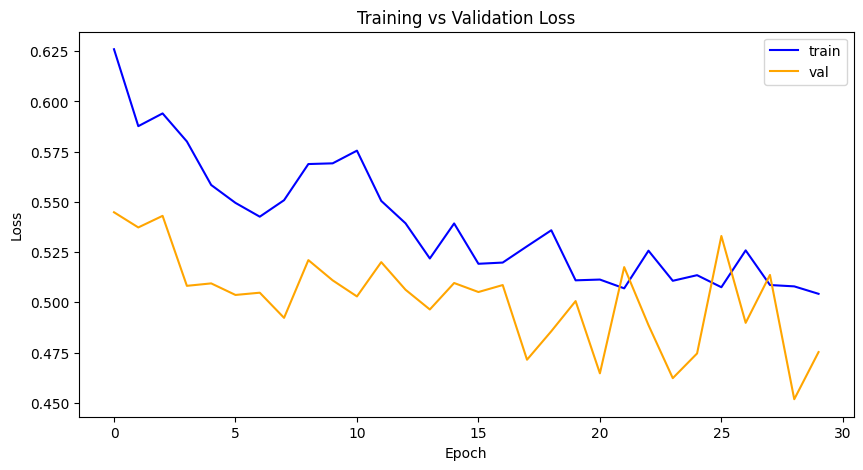

In [55]:
metric_df = pd.read_csv(f'experiments/ccp_unet/version_0/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

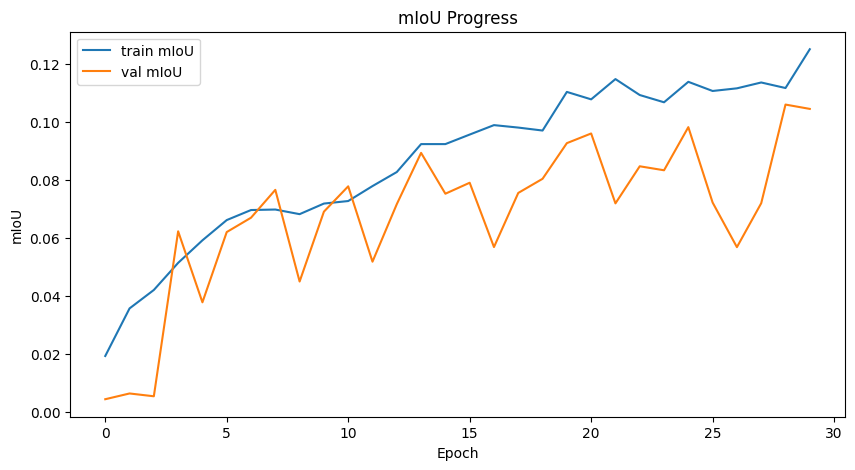

In [56]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_miou_epoch.plot(ax=ax, label='train mIoU')
metric_df.val_miou.plot(ax=ax, label='val mIoU')

ax.set_xlabel('Epoch')
ax.set_ylabel('mIoU')
ax.set_title('mIoU Progress')
ax.legend()
plt.show()


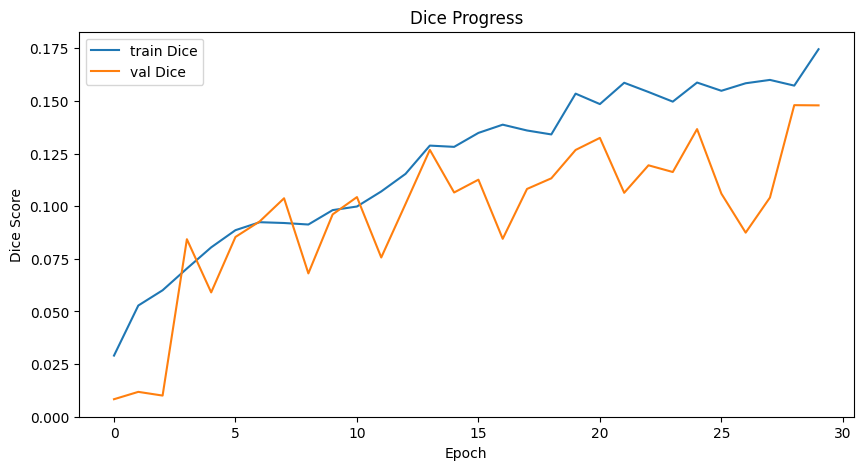

In [57]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_dice_epoch.plot(ax=ax, label='train Dice')
metric_df.val_dice.plot(ax=ax, label='val Dice')

ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Progress')
ax.legend()
plt.show()


# DeepLab v3 plus

In [58]:
model = smp.DeepLabV3Plus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [59]:
NUM_CLASSES = 59  # CCP has 59 classes

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # DeepLabV3+ model
        self.model = smp.DeepLabV3Plus(
            encoder_name='resnet101',     # better accuracy
            encoder_weights='imagenet',
            in_channels=3,
            classes=59,
            encoder_output_stride=16      # better detail
        )

        # Metrics
        self.dice_loss = DiceLoss(mode='multiclass', from_logits=True)

        self.train_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)
        self.val_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)

        # Use F1Score as Dice proxy
        self.train_dice = MulticlassF1Score(num_classes=NUM_CLASSES)
        self.val_dice = MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_miou', iou, on_epoch=True)
        self.log('train_dice', dice, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_miou', iou, on_epoch=True)
        self.log('val_dice', dice, on_epoch=True)

        return loss



In [60]:
pl.seed_everything(seed=42, workers=True)

lightning_module = LightningModule()

csv_logger = CSVLogger(
    save_dir=os.getcwd(),
    name="experiments/ccp_deeplabv3plus"
)

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    filename='best_valid_loss',
    verbose=True,
    save_last=False
)

trainer = pl.Trainer(
    max_epochs=30,
    logger=csv_logger,
    callbacks=[model_checkpoint_callback]
)

data_module = DataModule(df, bs=64, ps=224)

trainer.fit(lightning_module, data_module)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | DeepLabV3Plus          | 45.7 M | train
1 | dice_loss  | DiceLoss               | 0      | train
2 | train_iou  | MulticlassJaccardIndex | 0      | train
3 | val_iou    | MulticlassJaccardIndex | 0      | train
4 | train_dice | MulticlassF1Score      | 0      | train
5 | val_dice   | MulticlassF1Score      | 0      | train
--------------------------------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.738   Total estimated model params size (MB)
348       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 0.53784 (best 0.53784), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 44: 'val_loss' reached 0.53459 (best 0.53459), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 55: 'val_loss' reached 0.52372 (best 0.52372), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 66: 'val_loss' reached 0.49936 (best 0.49936), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 77: 'val_loss' reached 0.49604 (best 0.49604), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 88: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 99: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 110: 'val_loss' reached 0.49298 (best 0.49298), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 121: 'val_loss' reached 0.47407 (best 0.47407), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 132: 'val_loss' reached 0.46510 (best 0.46510), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 143: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 154: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 165: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 176: 'val_loss' reached 0.43914 (best 0.43914), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/ccp_deeplabv3plus/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 187: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 198: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 209: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 220: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 231: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 242: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 253: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 275: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 286: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 297: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 308: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 319: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 330: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


   epoch  step  train_dice_epoch  train_dice_step  train_loss_epoch  \
0      0    10          0.049740              NaN          0.608195   
1      1    21          0.075438              NaN          0.581845   
2      2    32          0.099349              NaN          0.557183   
3      3    43          0.102445              NaN          0.553389   
4      4    49          0.114830         0.134239          0.558502   

   train_loss_step  train_miou_epoch  train_miou_step  val_dice  val_loss  \
0              NaN          0.031856              NaN  0.033920  0.537841   
1              NaN          0.051371              NaN  0.046389  0.539083   
2              NaN          0.068894              NaN  0.029948  0.582675   
3              NaN          0.071468              NaN  0.086733  0.534591   
4         0.471378          0.080343         0.094489  0.061421  0.523718   

   val_miou  
0  0.020721  
1  0.031071  
2  0.016808  
3  0.057925  
4  0.040234  


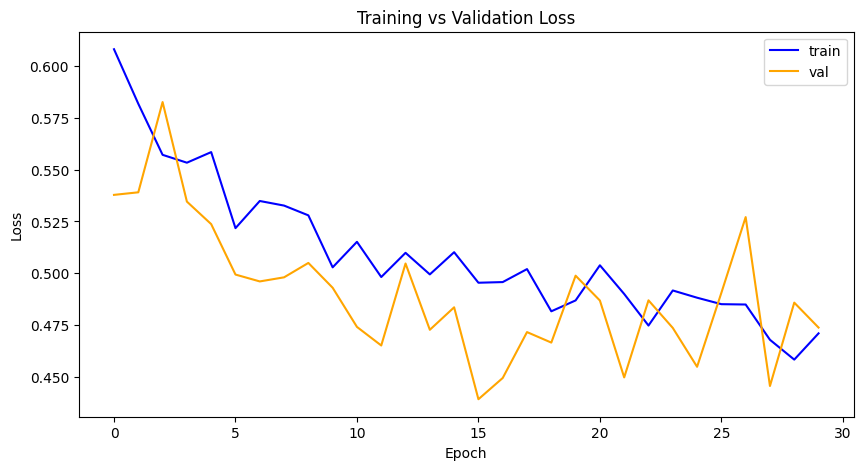

In [61]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

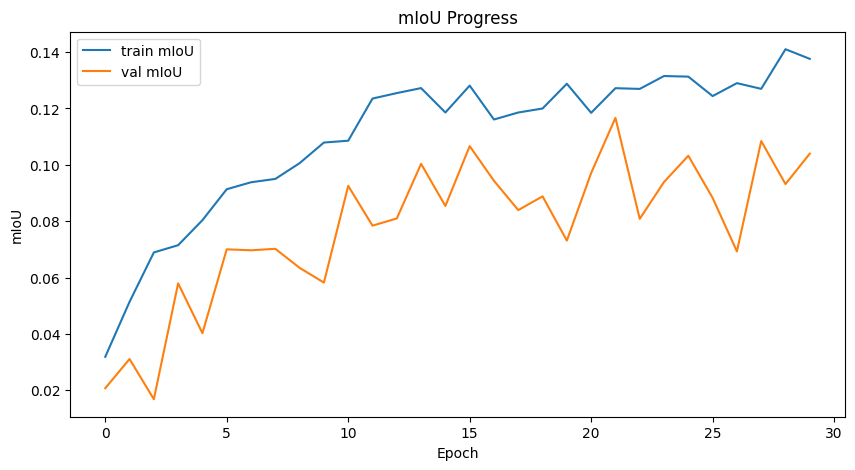

In [62]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_miou_epoch.plot(ax=ax, label='train mIoU')
metric_df.val_miou.plot(ax=ax, label='val mIoU')

ax.set_xlabel('Epoch')
ax.set_ylabel('mIoU')
ax.set_title('mIoU Progress')
ax.legend()
plt.show()


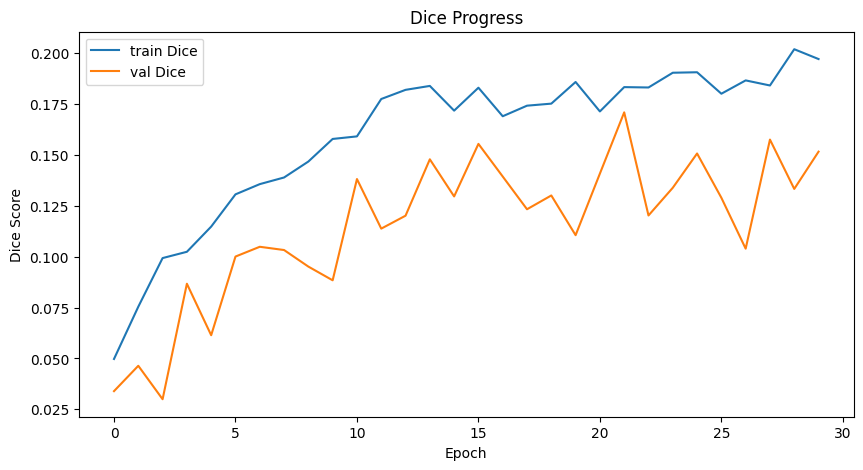

In [63]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_dice_epoch.plot(ax=ax, label='train Dice')
metric_df.val_dice.plot(ax=ax, label='val Dice')

ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Progress')
ax.legend()
plt.show()


# FPN

In [66]:
model = smp.FPN(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [67]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score

NUM_CLASSES = 59  # CCP has 59 classes

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # FPN model
        self.model = smp.FPN(
            encoder_name='resnet50',
            encoder_weights='imagenet',
            in_channels=3,
            classes=NUM_CLASSES
        )

        # Metrics
        self.dice_loss = DiceLoss(mode='multiclass', from_logits=True)

        self.train_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)
        self.val_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)

        # Use F1Score as Dice proxy
        self.train_dice = MulticlassF1Score(num_classes=NUM_CLASSES)
        self.val_dice = MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_miou', iou, on_epoch=True)
        self.log('train_dice', dice, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_miou', iou, on_epoch=True)
        self.log('val_dice', dice, on_epoch=True)

        return loss


In [68]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Intantiate LightningModule
lightning_module = LightningModule()

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="experiments/fpn")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=30, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = DataModule(df, bs=64, ps=224)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | FPN                    | 26.1 M | train
1 | dice_loss  | DiceLoss               | 0      | train
2 | train_iou  | MulticlassJaccardIndex | 0      | train
3 | val_iou    | MulticlassJaccardIndex | 0      | train
4 | train_dice | MulticlassF1Score      | 0      | train
5 | val_dice   | MulticlassF1Score      | 0      | train
--------------------------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.494   Total estimated model params size (MB)
214       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 0.55044 (best 0.55044), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' reached 0.50966 (best 0.50966), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 44: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 55: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 66: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 77: 'val_loss' reached 0.48245 (best 0.48245), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 88: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 99: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 110: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 121: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 132: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 143: 'val_loss' reached 0.47370 (best 0.47370), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 154: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 165: 'val_loss' reached 0.46751 (best 0.46751), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 176: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 187: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 198: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 209: 'val_loss' reached 0.46206 (best 0.46206), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 220: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 231: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 242: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 253: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 275: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 286: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 297: 'val_loss' reached 0.45505 (best 0.45505), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 308: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 319: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 330: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


   epoch  step  train_dice_epoch  train_dice_step  train_loss_epoch  \
0      0    10          0.019924              NaN          0.612040   
1      1    21          0.056888              NaN          0.589240   
2      2    32          0.069597              NaN          0.572466   
3      3    43          0.088133              NaN          0.564238   
4      4    49          0.096067         0.106598          0.555018   

   train_loss_step  train_miou_epoch  train_miou_step  val_dice  val_loss  \
0              NaN          0.011375              NaN  0.010917  0.550441   
1              NaN          0.036976              NaN  0.049576  0.556947   
2              NaN          0.046388              NaN  0.073400  0.509657   
3              NaN          0.059030              NaN  0.068067  0.528106   
4         0.531377          0.064291         0.070893  0.077194  0.518268   

   val_miou  
0  0.005822  
1  0.031820  
2  0.048456  
3  0.043079  
4  0.052212  


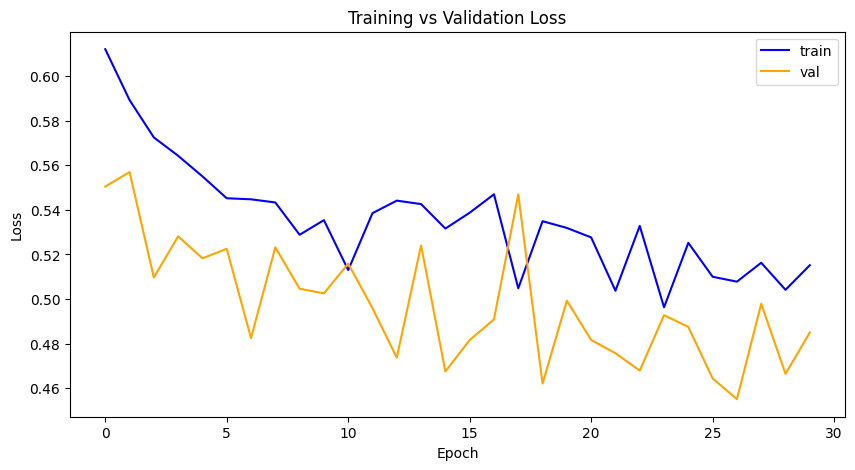

In [69]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

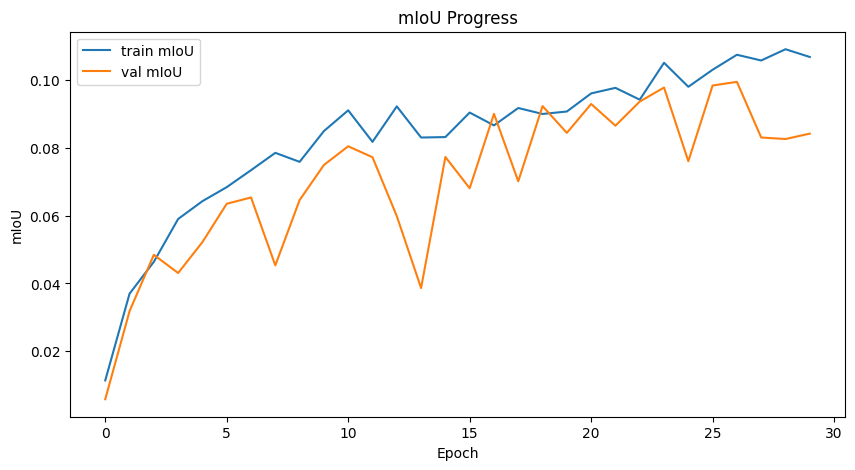

In [70]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_miou_epoch.plot(ax=ax, label='train mIoU')
metric_df.val_miou.plot(ax=ax, label='val mIoU')

ax.set_xlabel('Epoch')
ax.set_ylabel('mIoU')
ax.set_title('mIoU Progress')
ax.legend()
plt.show()


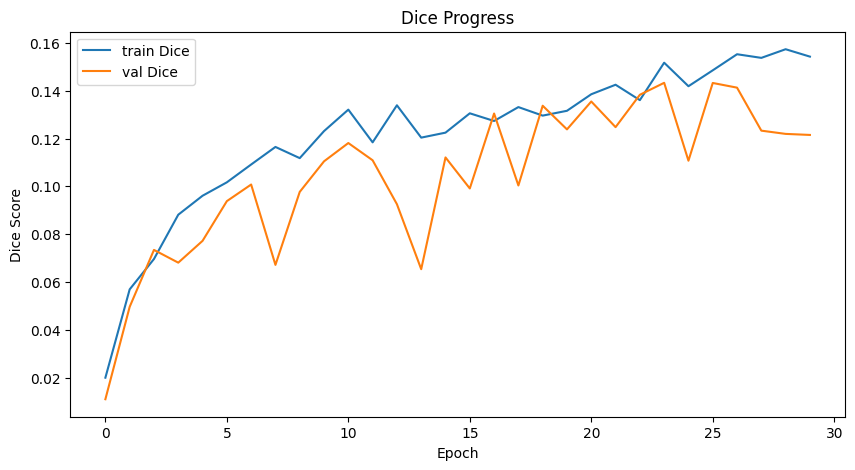

In [71]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_dice_epoch.plot(ax=ax, label='train Dice')
metric_df.val_dice.plot(ax=ax, label='val Dice')

ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Progress')
ax.legend()
plt.show()


# PSPnet

In [72]:
model = smp.PSPNet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=59
)

model

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [73]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score

NUM_CLASSES = 59  # CCP has 59 classes

class LightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # FPN model
        self.model = smp.UnetPlusPlus(
            encoder_name='resnet50',
            encoder_weights='imagenet',
            in_channels=3,
            classes=NUM_CLASSES
        )

        # Metrics
        self.dice_loss = DiceLoss(mode='multiclass', from_logits=True)

        self.train_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)
        self.val_iou = MulticlassJaccardIndex(num_classes=NUM_CLASSES)

        # Use F1Score as Dice proxy
        self.train_dice = MulticlassF1Score(num_classes=NUM_CLASSES)
        self.val_dice = MulticlassF1Score(num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_miou', iou, on_epoch=True)
        self.log('train_dice', dice, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.dice_loss(logits, y)

        preds = torch.argmax(logits, dim=1)

        # compute metrics
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_miou', iou, on_epoch=True)
        self.log('val_dice', dice, on_epoch=True)

        return loss


In [74]:
# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Intantiate LightningModule
lightning_module = LightningModule()

# Define a CSV logger to store training/validation metrics in CSV format.
csv_logger = CSVLogger(save_dir=os.getcwd(), name="experiments/pspnet")

# Define a checkpoint callback:
# It will save the model with the lowest validation loss ("best_valid_loss.ckpt").
model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

# Create a PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=30, logger=csv_logger, callbacks=[model_checkpoint_callback])

# Load the data module
data_module = DataModule(df, bs=64, ps=224)

# Train the model with the trainer, passing the core LightningModule and data module.
trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | UnetPlusPlus           | 49.0 M | train
1 | dice_loss  | DiceLoss               | 0      | train
2 | train_iou  | MulticlassJaccardIndex | 0      | train
3 | val_iou    | MulticlassJaccardIndex | 0      | train
4 | train_dice | MulticlassF1Score      | 0      | train
5 | val_dice   | MulticlassF1Score      | 0      | train
--------------------------------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.977   Total estimated model params size (MB)
306       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 11: 'val_loss' reached 0.55996 (best 0.55996), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 22: 'val_loss' reached 0.55470 (best 0.55470), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 33: 'val_loss' reached 0.53195 (best 0.53195), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 44: 'val_loss' reached 0.51452 (best 0.51452), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1
Traceback (most recent call last):
  File "/home/alumno/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/queues.py", line 268, in _feed
    send_bytes(obj)
    ~~~~~~~~~~^^^^^
  File "/home/alumno/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alumno/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
    ~~~~~~~~~~^^^^^^^^^^^^^^
  File "/home/alumno/.local/share/uv/python/cpython-3.13.7-linux-x86_64-gnu/lib/python3.13/multiprocessing/connection

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 55: 'val_loss' reached 0.50188 (best 0.50188), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 66: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 77: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 88: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 99: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 110: 'val_loss' reached 0.47468 (best 0.47468), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 121: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 132: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 143: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 154: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 165: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 176: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 187: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 198: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 209: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 220: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 231: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 242: 'val_loss' reached 0.47074 (best 0.47074), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 253: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 264: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 275: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 286: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 297: 'val_loss' reached 0.46790 (best 0.46790), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 308: 'val_loss' reached 0.45107 (best 0.45107), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 319: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 330: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


   epoch  step  train_dice_epoch  train_dice_step  train_loss_epoch  \
0      0    10          0.020199              NaN          0.604587   
1      1    21          0.040878              NaN          0.596994   
2      2    32          0.062345              NaN          0.574095   
3      3    43          0.064020              NaN          0.583590   
4      4    49          0.069497         0.061885          0.577306   

   train_loss_step  train_miou_epoch  train_miou_step  val_dice  val_loss  \
0              NaN          0.011960              NaN  0.014972  0.559957   
1              NaN          0.026725              NaN  0.029616  0.554696   
2              NaN          0.043936              NaN  0.031891  0.531946   
3              NaN          0.045534              NaN  0.053669  0.514521   
4         0.556771          0.049647         0.042759  0.068629  0.501879   

   val_miou  
0  0.008582  
1  0.018109  
2  0.019087  
3  0.036799  
4  0.049440  


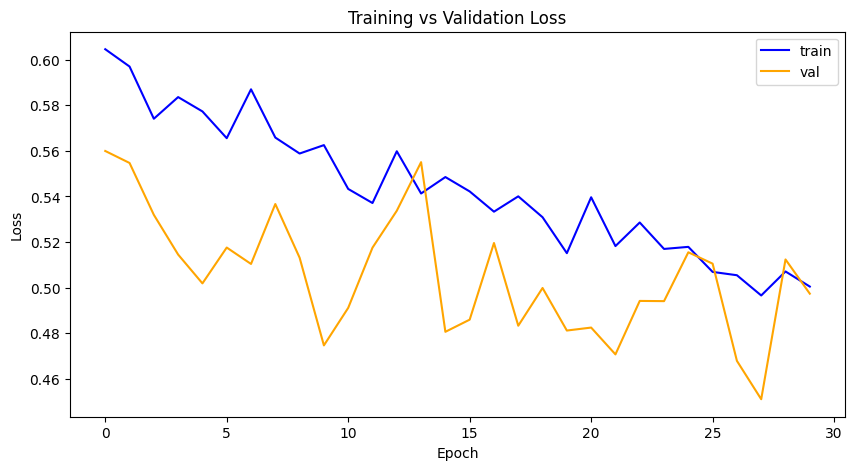

In [75]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()
print(metric_df.head())

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss_epoch.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

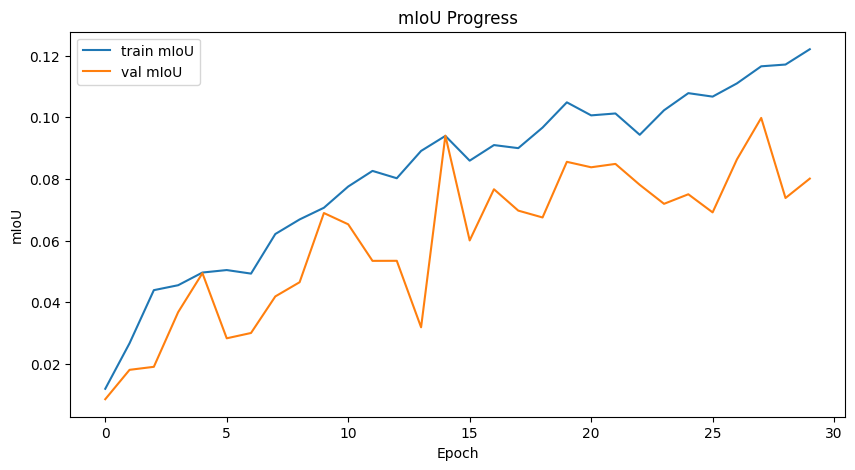

In [76]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_miou_epoch.plot(ax=ax, label='train mIoU')
metric_df.val_miou.plot(ax=ax, label='val mIoU')

ax.set_xlabel('Epoch')
ax.set_ylabel('mIoU')
ax.set_title('mIoU Progress')
ax.legend()
plt.show()


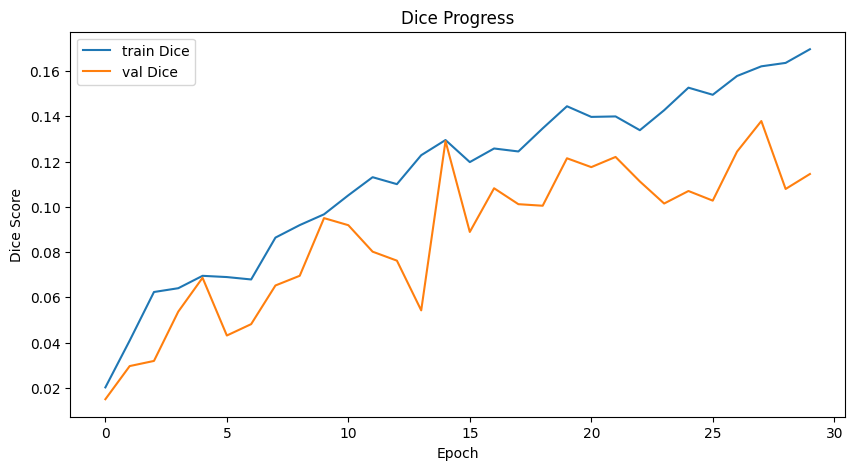

In [77]:
f, ax = plt.subplots(figsize=(10, 5))
metric_df.train_dice_epoch.plot(ax=ax, label='train Dice')
metric_df.val_dice.plot(ax=ax, label='val Dice')

ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Progress')
ax.legend()
plt.show()
